In [1]:
%pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model

In [3]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)

In [4]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [6]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input,decode_predictions

shape of x:  (1, 224, 224, 3)
data type:  float32


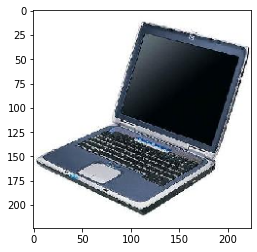

In [7]:
img, x = load_image("./101_ObjectCategories/laptop/image_0001.jpg")
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)



In [8]:
predictions = model.predict(x)

# print out the 
for _, pred, prob in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred, prob))

1/1 [==============================] - 1s 969ms/step
predicted notebook with probability 0.632
predicted hand-held_computer with probability 0.164
predicted laptop with probability 0.083
predicted honeycomb with probability 0.026
predicted space_bar with probability 0.016


In [9]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

1/1 [==============================] - 1s 701ms/step


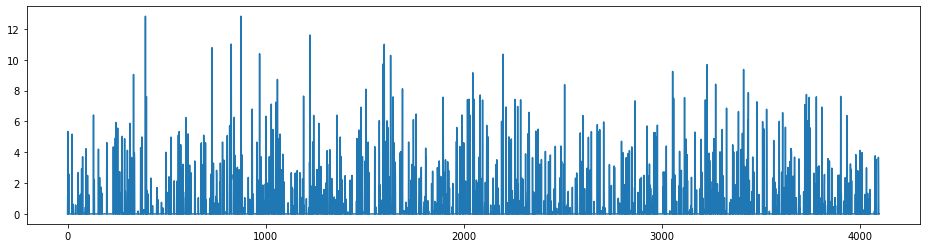

In [10]:
img, x = load_image("./101_ObjectCategories/laptop/image_0001.jpg")
feat = feat_extractor.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])

In [11]:
import sys
import time
import random
images_path = './101_ObjectCategories'
image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
max_num_images = 10000

tick=time.time()

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(range(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 10000 images to analyze


In [12]:
tic=time.time()
features = []
for i, image_path in enumerate(images):
    if i % 500 == 0:
        toc = time.time()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        tic = time.time()
    img, x = load_image(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

print('finished extracting features for %d images' % len(images))

analyzing image 0 / 10000. Time: 0.0000 seconds.
1/1 [==============================] - 0s 398ms/step
analyzing image 500 / 10000. Time: 294.3389 seconds.
1/1 [==============================] - 0s 407ms/step
analyzing image 1000 / 10000. Time: 271.8747 seconds.
1/1 [==============================] - 0s 438ms/step
analyzing image 1500 / 10000. Time: 327.8685 seconds.
1/1 [==============================] - 0s 441ms/step
analyzing image 2000 / 10000. Time: 326.5386 seconds.
1/1 [==============================] - 0s 441ms/step
analyzing image 2500 / 10000. Time: 277.9306 seconds.
1/1 [==============================] - 0s 399ms/step
analyzing image 3000 / 10000. Time: 274.0241 seconds.
1/1 [==============================] - 0s 414ms/step
analyzing image 3500 / 10000. Time: 235.2077 seconds.
1/1 [==============================] - 0s 381ms/step
analyzing image 4000 / 10000. Time: 234.0599 seconds.
1/1 [==============================] - 0s 376ms/step
analyzing image 4500 / 10000. Time: 247.498

In [13]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [14]:
import sklearn
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)

PCA(n_components=300)

In [15]:
pca_features = pca.transform(features)

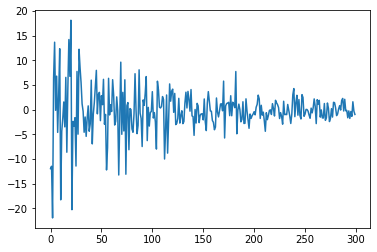

In [16]:
plt.plot(pca_features[2])

In [17]:
tock= time.time()
print(tock-tick)

12372.71162366867


In [18]:
from scipy.spatial import distance

def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

In [19]:
def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

1/1 [==============================] - 0s 345ms/step


Text(0.5, 1.0, 'result images')

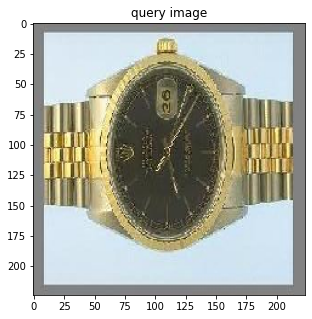

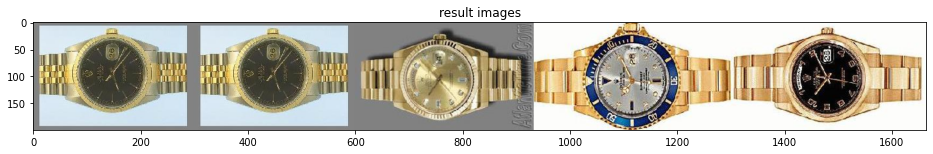

In [28]:
new_image, x = load_image("./101_ObjectCategories/watch/image_0030.jpg")
new_features = feat_extractor.predict(x)

# project it into pca space
new_pca_features = pca.transform(new_features)[0]

# calculate its distance to all the other images pca feature vectors
distances = [ distance.cosine(new_pca_features, feat) for feat in pca_features ]
idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[0:5]  # grab first 5
results_image = get_concatenated_images(idx_closest, 200)

# display the results
plt.figure(figsize = (5,5))
plt.imshow(new_image)
plt.title("query image")

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

In [26]:
# saving the query image and the result images to the desk
from uuid import uuid4
images_directory = r"D:\object_detection_rank"
query_image_name = str(uuid4())+".jpg"
query_image_path = images_directory + "\\" +query_image_name
new_image.save(query_image_path)
from PIL import Image
im = Image.fromarray(results_image)
result_images_name = str(uuid4())+".jpg"
result_images_path = images_directory + "\\"+ result_images_name
im.save(result_images_path)

In [22]:
!pip install mysql-connector

In [23]:
import mysql.connector
mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="",
    database="paths"
)
print(mydb)

In [29]:
mycursor = mydb.cursor()
mycursor.execute("insert into stored(query, results) values(%s, %s)", [query_image_name, result_images_name])
mydb.commit()
